# 교차 검증과 그리드 서치  
---

## 검증 세트  
---

훈련 세트 60%, 검정 세트 20%, 테스트 세트 20%

In [1]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [2]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [3]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [4]:
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [5]:
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [6]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


과대적합이므로 매개변수를 바꿔서 다른 더 좋은 모델을 찾아야 함

## 교차 검증  
---

많은 데이터를 사용할수록 좋은 모델이 만들어지는데 그렇다고 검증 세트를 조금 뗴어 놓으면 점수가 들쭉날쭉하고 불안정하기 때문에 사용

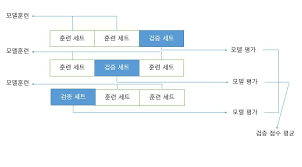

In [7]:
from sklearn.model_selection import cross_validate

scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.01854587, 0.01207185, 0.01907134, 0.01821637, 0.01930857]), 'score_time': array([0.00080776, 0.00074434, 0.00079775, 0.00087142, 0.00078869]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


fit_time,score_time은 훈련 시간과 검증 시간, test_score는 각 점수

In [8]:
import numpy as np

print(np.mean(scores['test_score']))

0.855300214703487


회귀일 때는 KFold클래스 사용  
분류일 때는 StratifiedKFold클래스 사용(섞을 수 있음)

In [9]:
from sklearn.model_selection import StratifiedKFold

scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


In [10]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


## 하이퍼파라미터 튜닝  
---

사용자가 직접 지정하는 파라미터를 하이퍼파라미터  
사이킷런 같은 머신 러닝 라이브러리를 사용할 때는 클래스나 메소드의 매개변수로 표현

- 그리드 서치 사용

매개변수를 변경하면서 최적의 값을 찾아줌

사이킷런에는 그리드 서치 + 교차검증 존재

In [11]:
from sklearn.model_selection import GridSearchCV

params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [12]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

In [13]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

best_estimator_에는 점수가 가장 높은 모델이 저장되어 있음  
best_params_에는 점수가 가장 높은 모델의 파라미터가 저장

In [14]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [15]:
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [16]:
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [17]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


In [18]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }

In [19]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [20]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [21]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


### 랜덤 서치  
---

매개변수의 값이 수치일 때의 값의 범위나 간격을 미리 정하기 어려울 수 있음  
그리드 서치는 매개변수의 조건이 있어 수행 시간이 오래걸림

randint는 정수를 뽑고, uniform은 실수

In [22]:
from scipy.stats import uniform, randint

In [23]:
rgen = randint(0, 10)
rgen.rvs(10)

array([2, 4, 6, 6, 7, 0, 0, 4, 7, 6])

In [24]:
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([115,  94,  92,  98,  98,  94,  92,  98,  95, 124]))

In [25]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([7.85256969e-01, 6.17903362e-01, 6.74630219e-01, 2.57740845e-01,
       1.55895938e-01, 7.99926438e-01, 3.65283219e-04, 9.16323805e-01,
       2.78694357e-01, 3.88077774e-01])

min_samples_leaf 리프노드가 되기 위한 최소 샘플의 수  
어떤 노드가 분할하여 만들어질 자식 노드의 샘플 수가 이 보다 작으면 분할하지 않음

In [26]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

In [27]:
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, 
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f934a490c10>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f934a5b03a0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f934a6085b0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f934a5b0040>},
                   random_state=42)

In [28]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [29]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [30]:
dt = gs.best_estimator_

print(dt.score(test_input, test_target))

0.86


## 확인문제

In [31]:
gs = RandomizedSearchCV(DecisionTreeClassifier(splitter='random', random_state=42), params, 
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42,
                                                    splitter='random'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f934a490c10>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f934a5b03a0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f934a6085b0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f934a5b0040>},
                   random_state=42)

In [32]:
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))

dt = gs.best_estimator_
print(dt.score(test_input, test_target))

{'max_depth': 43, 'min_impurity_decrease': 0.00011407982271508446, 'min_samples_leaf': 19, 'min_samples_split': 18}
0.8458726956392981
0.786923076923077
